# BAM + VGG/ALexNet/ResNet on Traffic Sign Classification by Xiangsheng Gu

In [1]:
import os
import sys
import csv
import cv2
import time
import copy
import math
import random
import shutil
import warnings
import numpy as np
import seaborn as sns
from PIL import Image
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import namedtuple, OrderedDict
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import sklearn
from sklearn import decomposition
from sklearn import manifold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA

import torch
print(torch.__version__)
torch.cuda.is_available()
torch.cuda.device_count()

1.11.0


1

## Traffic Sign Image Data Exploration & Visualization

In [2]:

class SystemConfig:
    '''Describes the common system setting needed for reproducible training'''
    seed: int = 11 
    cudnn_benchmark_enabled: bool = True
    cudnn_deterministic: bool = True 
   


class TrainingConfig:
    '''Describes configuration of the training process'''
    device: str = 'cuda'
    model_save_best: bool = True
    batch_size: int = 32
    epochs_count: int = 12
    log_interval: int = 5  
    test_interval: int = 1  
    model_name: str = 'resnet50'
    num_workers: int = 4
    num_classes: int = 43
    data_augmentation: bool = True
    mean = [0.3447, 0.3131, 0.3243]
    std = [0.1565, 0.1575, 0.1670]


class DataConfig:
    root_dir: str = './dataset/GTSRB'
    train_dir: str = 'Train/'
    test_dir: str = 'Test/'
    train_csv: str = 'Train.csv'
    test_csv: str = 'Test.csv'
    model_dir: str = os.path.join('./dataset/GTSRB/', 'models/')
    log_dir: str = os.path.join('./dataset/GTSRB/', 'logs/')


class OptimizerConfig:
    init_learning_rate: float = 0.0001 
    weight_decay: float = 0.0001
    scheduler_step_size: int = 6
    scheduler_gamma: float = 0.1

    
def setup_system(system_config: SystemConfig) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic
        
sc = SystemConfig()
tc = TrainingConfig()
dc = DataConfig()
oc = OptimizerConfig()

setup_system(sc)


for path in [dc.log_dir, dc.model_dir]:
    if not os.path.exists(path):
        os.makedirs(path)
        
tb_writer = SummaryWriter(dc.log_dir)

In [3]:
train_file = os.path.join(dc.root_dir, dc.train_csv)
test_file = os.path.join(dc.root_dir, dc.test_csv)
df_train = pd.read_csv(train_file)
df_train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [4]:
df_test = pd.read_csv(test_file)
df_test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [5]:
print(f'Train csv shape: {df_train.shape}, \nTest csv shape: {df_test.shape}')

Train csv shape: (39209, 8), 
Test csv shape: (12630, 8)


Currently on row 0 of 39209
Currently on row 10000 of 39209
Currently on row 20000 of 39209
Currently on row 30000 of 39209


C:\Users\WillGu\AppData\Local\Temp/ipykernel_31944/713793994.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(imgs) / columns + 1, columns, i + 1)


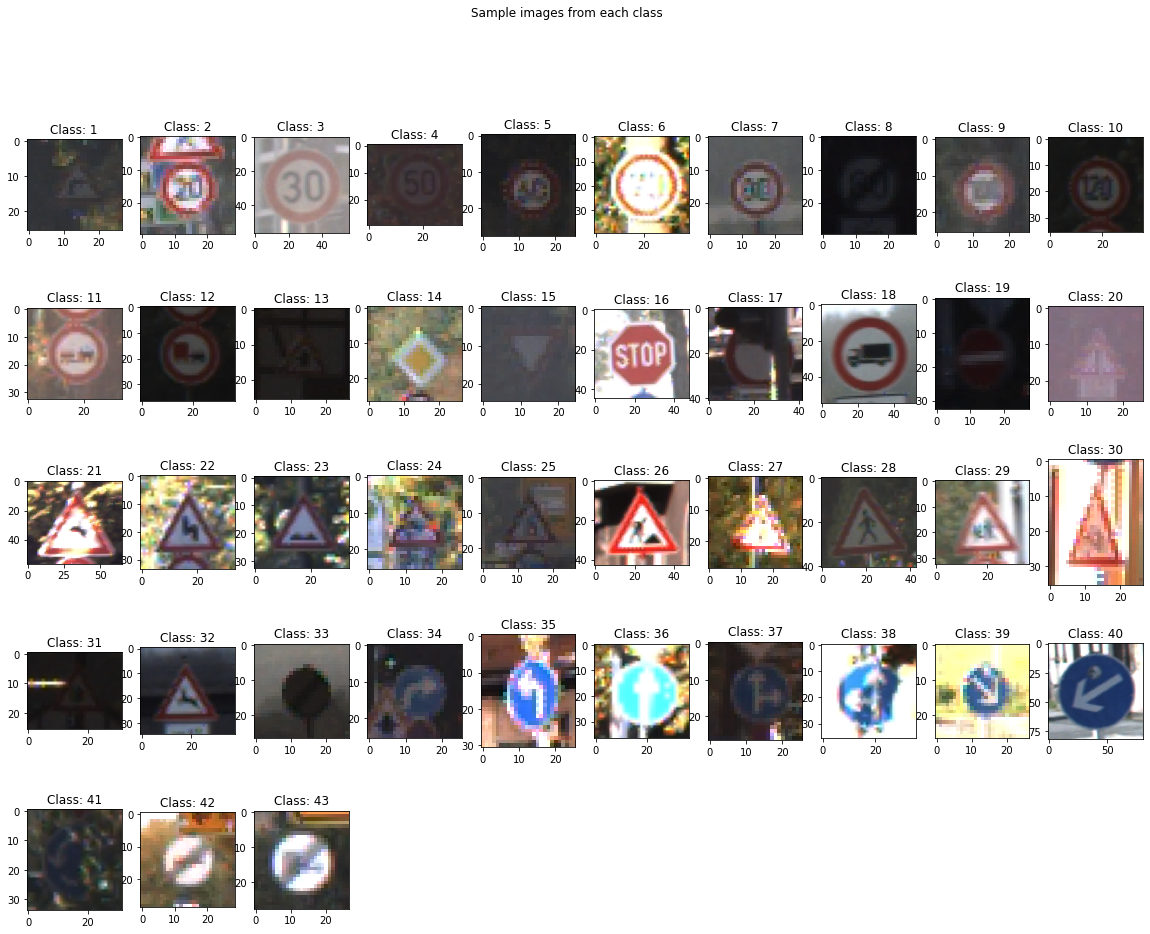

In [6]:
class_list = []
imgs = []
for index, data in df_train.iterrows():
    file_name = data['Path']
    class_id = data['ClassId']
    if class_id not in class_list:
      class_list.append(class_id)
      imgs.append(mpimg.imread(os.path.join(dc.root_dir,file_name)))
    if index % 10000 == 0:
      print(f'Currently on row {index} of 39209')

plt.figure(figsize=(20,15))
plt.suptitle('Sample images from each class')
columns = 10
for i, image in enumerate(imgs):
    plt.subplot(len(imgs) / columns + 1, columns, i + 1)
    plt.title(f'Class: {i+1}', color='black')
    plt.imshow(image)

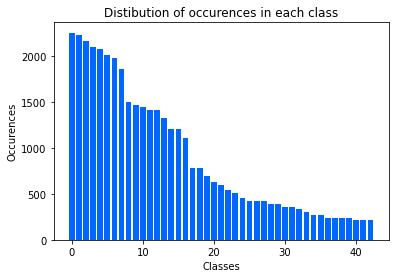

In [7]:
c = df_train['ClassId'].nunique()
x = df_train['ClassId'].value_counts()

plt.bar(x=x.index.sort_values(), height=x, color='#0066ff')
plt.title('Distibution of occurences in each class', color='black')
plt.xlabel("Classes", color='black')
plt.ylabel("Occurences", color='black')
plt.tick_params(colors='black')

## Preparation

In [8]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
class GTSR43Dataset(Dataset):
    """German Traffic Sign Recognition dataset."""
    def __init__(self, root_dir, train_file, transform=None):
        self.root_dir = root_dir
        self.train_file_path = train_file
        self.label_df = pd.read_csv(os.path.join(self.root_dir, self.train_file_path))
        self.transform = transform
        self.classes = list(self.label_df['ClassId'].unique())

    def __getitem__(self, idx):
        """Return (image, target) after resize and preprocessing."""
        img = os.path.join(self.root_dir, self.label_df.iloc[idx, 7])
        
        X = Image.open(img)
        y = self.class_to_index(self.label_df.iloc[idx, 6])

        if self.transform:
            X = self.transform(X)

        return X, y
    
    def class_to_index(self, class_name):
        """Returns the index of a given class."""
        return self.classes.index(class_name)
    
    def index_to_class(self, class_index):
        """Returns the class of a given index."""
        return self.classes[class_index] 
    
    def get_class_count(self):
        """Return a list of label occurences"""
        cls_count = dict(self.label_df.ClassId.value_counts())
#         cls_percent = list(map(lambda x: (1 - x / sum(cls_count)), cls_count))
        return cls_count
    
    def __len__(self):
        """Returns the length of the dataset."""
        return len(self.label_df)

class GTSR43Subset(GTSR43Dataset):
    """A subset helper class for splitting the main dataset"""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        """Retrieves one item from the dataset."""
        X, y = self.subset[idx]
        
        if self.transform:
            X = self.transform(X)

        return X, y

    def __len__(self):
        return len(self.subset)
    
class GTSR43Testset(Dataset):
    """German Traffic Sign Recognition dataset"""
    def __init__(self, root_dir, test_file, transform=None):
        self.root = root_dir
        self.test_file_path = test_file
        self.label_df = pd.read_csv(os.path.join(self.root_dir, self.test_file_path))
        self.transform = transform

    def __getitem__(self, idx):
        """Retrieves one item from the dataset."""
        img = os.path.join(self.root_dir, self.label_df.iloc[idx, 7])
        
        image = Image.open(img)

        if self.transform:
            image = self.transform(image)

        return image
    
    def __len__(self):
        return len(self.label_df)

In [9]:
ds = GTSR43Dataset(dc.root_dir, dc.train_csv)
X, y = ds.__getitem__(5)
print(f'Train image: {X}\nTarget class: {y}\nClass count: {ds.get_class_count()}')

Train image: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=31x27 at 0x1A6E2FFC1C0>
Target class: 0
Class count: {2: 2250, 1: 2220, 13: 2160, 12: 2100, 38: 2070, 10: 2010, 4: 1980, 5: 1860, 25: 1500, 9: 1470, 7: 1440, 3: 1410, 8: 1410, 11: 1320, 18: 1200, 35: 1200, 17: 1110, 14: 780, 31: 780, 33: 689, 15: 630, 26: 600, 28: 540, 23: 510, 30: 450, 16: 420, 6: 420, 34: 420, 22: 390, 36: 390, 40: 360, 20: 360, 21: 330, 39: 300, 29: 270, 24: 270, 32: 240, 27: 240, 41: 240, 42: 240, 37: 210, 0: 210, 19: 210}


In [10]:
def image_resize():
    """Transforms for resizing, cropping."""
    resize_transforms = transforms.Compose([transforms.Resize(32),
                                            transforms.CenterCrop(30),
                                           ])
    return resize_transforms

def image_preprocess():
    """Transforms for resizing, cropping, then converting to Tensor."""
    preprocess_transforms = transforms.Compose([transforms.Resize(32),
                                                transforms.CenterCrop(30),
                                                transforms.ToTensor()
                                               ])
    return preprocess_transforms

def common_transforms(mean, std):
    """Transforms which are common to both the train and test set.""" 
    common_transforms = transforms.Compose([image_preprocess(),
                                            transforms.Normalize(mean, std)
                                           ])
    return common_transforms

def data_aug(mean, std):
    """Data augmentation transforms."""
    data_aug_transforms = transforms.Compose([transforms.Resize(32),
                                              transforms.CenterCrop(30),
                                              transforms.RandomVerticalFlip(),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ColorJitter(),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean, std),
                                              transforms.RandomErasing(),
                                             ])        
    return data_aug_transforms

In [11]:
def get_data(root_dir, batch_size, num_workers=4, data_augmentation=False):
    """Loads and splits data into train and test subsets. """  
    dataset = GTSR43Dataset(root_dir, dc.train_csv)
    
    if data_augmentation:
        X_transforms = data_aug(tc.mean, tc.std)
    else:
        X_transforms = common_transforms(tc.mean, tc.std)
    
    y_transforms = common_transforms(tc.mean, tc.std)
    
    X_size = int(0.8 * len(dataset))
    y_size = len(dataset) - X_size
    
    X_dataset, y_dataset = torch.utils.data.random_split(dataset, [X_size, y_size])
    
    X_subset = GTSR43Subset(X_dataset, X_transforms)
    y_subset = GTSR43Subset(y_dataset, y_transforms)

    X_loader = DataLoader(X_subset, 
                          batch_size=batch_size, 
                          shuffle=False,
                          num_workers=num_workers)  
    
    y_loader = DataLoader(y_subset,
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=num_workers)
    
    return X_loader, y_loader

## ResNet50

In [12]:
import torch.nn as nn
def train(tc: TrainingConfig, 
          model: nn.Module, 
          optimizer: torch.optim.Optimizer,
          X_loader: torch.utils.data.DataLoader, 
          epoch_idx: int) -> None:
    
    model.train()
    
    batch_loss = np.array([])
    batch_acc = np.array([])
    
    for batch, (X, y) in enumerate(X_loader):
        
        if batch == 0:
            print(f'Device: {torch.cuda.get_device_name(0)}, Data: {X.shape}, Target: {y.shape}')       

        index_y = y.clone()
        X = X.to(tc.device)
        y = y.to(tc.device)
        
        optimizer.zero_grad()
        output = model(X)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        prob = F.softmax(output, dim=1)
        pred = prob.data.max(dim=1)[1]  
        correct = pred.cpu().eq(index_y).sum()
        acc = float(correct) / float(len(X))
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = 100. * batch_acc.mean()
    
    print(f'Training   - loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.2f}%')
    
    return epoch_loss, epoch_acc

In [13]:
def validate(tc: TrainingConfig,
             model: nn.Module,
             y_loader: torch.utils.data.DataLoader) -> float:

    model.eval()
    
    loss = 0.0
    correct = 0.0
    for X, y in y_loader:
        index_y = y.clone()
        
        X = X.to(tc.device)
        y = y.to(tc.device)

        output = model(X)
        loss += F.cross_entropy(output, y).item()
        prob = F.softmax(output, dim=1)
        pred = prob.data.max(dim=1)[1] 
        correct += pred.cpu().eq(index_y).sum()

    loss = loss / len(y_loader)  
    accuracy = 100. * correct / len(y_loader.dataset)
    
    print(f'Validation - loss: {loss:.4f}, accuracy: {accuracy:.2f}%, {correct}/{len(y_loader.dataset)}')
    
    return loss, accuracy/100.0

In [14]:
class TrainingConfig:
    '''Describes configuration of the training process'''
    device: str = 'cuda'
    model_save_best: bool = True
    batch_size: int = 32
    epochs_count: int = 16
    log_interval: int = 5  
    test_interval: int = 1  
    model_name: str = 'resnet50'
    num_workers: int = 4
    num_classes: int = 43
    data_augmentation: bool = False
    mean = [0.3447, 0.3131, 0.3243]
    std = [0.1565, 0.1575, 0.1670]

tc = TrainingConfig()

## BAM + ResNet-50

In [15]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        # Bottleneck Attention Module(BAM)
        bam = BAMBlock(channel=256,reduction=8,dia_val=2)
        x = bam(x)
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [16]:
# model = models.resnet50(pretrained=True, progress=True)
model = ResNet50(43, 3)

# Freeze model parameters    
for param in model.parameters():
    param.requires_grad = False   
    
    model.fc = nn.Sequential(nn.Linear(2048, 512),
                             nn.ReLU(inplace=True),
                             nn.Dropout(0.5),
                             
                             nn.Linear(512, 512), 
                             nn.ReLU(inplace=True),
                             nn.Dropout(0.2),
                             
                             nn.Linear(512, tc.num_classes))

layers = [model.layer2,
          model.layer3,
          model.layer4,
          model.avgpool]

for layer in layers:
    for param in layer.parameters():
        # Unfreeze certain layers
        param.requires_grad = True

def trainable_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)
            
print("Layers: \n")
for name, child in model.named_children():
    print(name)

print("\nCurrent Trainable Parameters: \n")
print(trainable_parameters(model))

Layers: 

conv1
batch_norm1
relu
max_pool
layer1
layer2
layer3
layer4
avgpool
fc

Current Trainable Parameters: 

layer2.0.conv1.weight
layer2.0.conv1.bias
layer2.0.batch_norm1.weight
layer2.0.batch_norm1.bias
layer2.0.conv2.weight
layer2.0.conv2.bias
layer2.0.batch_norm2.weight
layer2.0.batch_norm2.bias
layer2.0.conv3.weight
layer2.0.conv3.bias
layer2.0.batch_norm3.weight
layer2.0.batch_norm3.bias
layer2.0.i_downsample.0.weight
layer2.0.i_downsample.0.bias
layer2.0.i_downsample.1.weight
layer2.0.i_downsample.1.bias
layer2.1.conv1.weight
layer2.1.conv1.bias
layer2.1.batch_norm1.weight
layer2.1.batch_norm1.bias
layer2.1.conv2.weight
layer2.1.conv2.bias
layer2.1.batch_norm2.weight
layer2.1.batch_norm2.bias
layer2.1.conv3.weight
layer2.1.conv3.bias
layer2.1.batch_norm3.weight
layer2.1.batch_norm3.bias
layer2.2.conv1.weight
layer2.2.conv1.bias
layer2.2.batch_norm1.weight
layer2.2.batch_norm1.bias
layer2.2.conv2.weight
layer2.2.conv2.bias
layer2.2.batch_norm2.weight
layer2.2.batch_norm2.bia

In [17]:
def main(model, optimizer, tb_writer, scheduler = None, data_augmentation = True):

    if torch.cuda.is_available():
        tc.device = "cuda"
    else:
        tc.device = "cpu"
        batch_size_to_set = 10
        num_workers_to_set = 2
    
    model.to(tc.device)
    
    X_loader, y_loader = get_data(root_dir=dc.root_dir, 
                                  batch_size=tc.batch_size, 
                                  num_workers=tc.num_workers, 
                                  data_augmentation=tc.data_augmentation)
    
    best_loss = torch.tensor(np.inf)
    
    epoch_X_loss = np.array([])
    epoch_y_loss = np.array([])
    epoch_X_acc = np.array([])
    epoch_y_acc = np.array([])
    
    t_begin = time.time()      
                            
    for epoch in range(tc.epochs_count):
        print(f'\nEpoch: {epoch + 1}/{tc.epochs_count}')    
        
        X_loss, X_acc = train(tc=tc, 
                              model=model, 
                              optimizer=optimizer, 
                              X_loader=X_loader, 
                              epoch_idx=epoch)

        epoch_X_loss = np.append(epoch_X_loss, [X_loss])
        epoch_X_acc = np.append(epoch_X_acc, [X_acc])
                                
        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(X_loader)
        eta = speed_epoch * tc.epochs_count - elapsed_time

        tb_writer.add_scalar('Loss/Train', X_loss, epoch)
        tb_writer.add_scalar('Accuracy/Train', X_acc, epoch)
        tb_writer.add_scalar('Time/elapsed_time', elapsed_time, epoch)
        tb_writer.add_scalar('Time/speed_epoch', speed_epoch, epoch)
        tb_writer.add_scalar('Time/speed_batch', speed_batch, epoch)
        tb_writer.add_scalar('Time/eta', eta, epoch)
                             
        if epoch % tc.test_interval == 0:

            current_loss, current_acc = validate(tc, model, y_loader)
                                                 
            epoch_y_loss = np.append(epoch_y_loss, [current_loss])
            epoch_y_acc = np.append(epoch_y_acc, [current_acc])
                                    
            if current_loss < best_loss:
                best_loss = current_loss
                save_model(model, device = tc.device, accuracy = current_acc)
                print('Model Improved! Saved!')

            tb_writer.add_scalar('Loss/Validation', current_loss, epoch)
            tb_writer.add_scalar('Accuracy/Validation', current_acc, epoch)
            tb_writer.add_scalars('Loss/train-val', {'train': X_loss, 'validation': current_loss}, epoch)
            tb_writer.add_scalars('Accuracy/train-val', {'train': X_acc,'validation': current_acc}, epoch)
                                  
        if scheduler is not None:
            scheduler.step()  

        print(f'Time: {elapsed_time:.2f}s, {speed_epoch:.2f} s/epoch, {speed_batch:.2f} s/batch, Learning rate: {scheduler.get_last_lr()[0]}') 
        
    print(f'Total time: {time.time() - t_begin:.2f}, Best loss: {best_loss:.3f}')    
    
    return model, epoch_X_loss, epoch_X_acc, epoch_y_loss, epoch_y_acc

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, utils
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=oc.init_learning_rate,
                             weight_decay=oc.weight_decay)

scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=oc.scheduler_step_size, 
                                      gamma=oc.scheduler_gamma)

print(f'Device: {tc.device}\n\
Epochs: {tc.epochs_count}\n\
Batch size: {tc.batch_size}\n\
Data Augmentation: {tc.data_augmentation}\n\
Scheduler step size: {oc.scheduler_step_size}\n\
Scheduler gamma: {oc.scheduler_gamma}\n\
Learning rate: {oc.init_learning_rate}\n\
L2 weight decay: {oc.weight_decay}')

model, train_loss, train_acc, val_loss, val_acc = main(model, 
                                                       optimizer, 
                                                       tb_writer, 
                                                       scheduler=scheduler, 
                                                       data_augmentation=tc.data_augmentation)

Device: cuda
Epochs: 16
Batch size: 32
Data Augmentation: False
Scheduler step size: 6
Scheduler gamma: 0.1
Learning rate: 0.0001
L2 weight decay: 0.0001

Epoch: 1/16


## VGG-16

In [ ]:
def produceImage(file_in, width, height, file_out):
    image = Image.open(file_in)
    resized_image = image.resize((width, height), Image.ANTIALIAS)
    resized_image.save(file_out)


class VGG_cls(nn.Module):
    def __init__(self):
        super(VGG_cls, self).__init__()
        self.backbone = models.vgg16(pretrained=True)
        self.SEblock = nn.Sequential(OrderedDict([
                ('SE1',   nn.Sequential(
                                        nn.Linear(512, 128),
                                        nn.ReLU())),
                ('SE2',   nn.Sequential(nn.Dropout(0.5),
                                        nn.Linear(128, 512)
                                        ))]))
        self.GAP = torch.nn.AdaptiveAvgPool2d(1)
        self.softmax = torch.nn.Softmax(dim=1)
        self.classifier = nn.Sequential(OrderedDict([
                ('fc1',   nn.Sequential(
                                        nn.Linear(512 * 7 * 7, 512),
                                        nn.ReLU())),
                ('fc2',   nn.Sequential(nn.Dropout(0.5),
                                        nn.Linear(512, 7)
                                        ))]))
    def forward(self,x):
        backbone_feat = self.backbone.features(x)
        feat_squeeze = self.GAP(backbone_feat).squeeze()
        SE_weight = self.softmax(self.SEblock(feat_squeeze))
        backbone_feat_SE = backbone_feat * SE_weight.unsqueeze(2).unsqueeze(2)
        backbone_feat_SE = backbone_feat_SE.view(-1, 512 * 7 * 7)
        score = self.classifier(backbone_feat_SE)
        return backbone_feat_SE, score
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "validation": transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

    image_path = './fer2013_dataset_resize/'  
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "training"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    exp_list = train_dataset.class_to_idx

    batch_size = 32
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "test"),
                                            transform=data_transform["validation"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))
    
    net = VGG_cls()
    net.to(device)
    loss_function = nn.CrossEntropyLoss()  #交叉熵损失函数
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    epochs = 60
    best_acc = 0.0
    save_path = './{}Net.pth'.format('vgg')
    train_steps = len(train_loader)
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader)
        
        confusion_matrix = torch.zeros((7,7),dtype=torch.int)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            feat,outputs = net(images.to(device))

            pred = torch.argmax(outputs.clone().detach().cpu(),dim=1)

            for cur_pred, cur_label in zip(pred, labels):
                confusion_matrix[cur_pred, cur_label] += 1
                
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)
        # print(confusion_matrix)

        # validate
        net.eval()
        acc = 0.0 
        with torch.no_grad():  #验证的过程不计算损失梯度
            val_bar = tqdm(validate_loader)
            for val_data in val_bar:
                val_images, val_labels = val_data
                feat,outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')


if __name__ == '__main__':
    main()

In [ ]:
model = models.Sequential() 
model.add(conv_base) 
model.add(layers.Flatten()) 
model.add(layers.Dense(512, 
            activation='relu',
            #kernel_regularizers=regularizers.l2(0.01)
            )) 
#model.add(layers.Dropout(0.5))

model.add(layers.Dense(43, activation='softmax')) 

conv_base.trainable = False

In [ ]:
conv_base.trainable = True 
 
set_trainable = False 
for layer in conv_base.layers: 
    if layer.name == 'block4_conv1': 
        set_trainable = True 
    if set_trainable: 
        layer.trainable = True 
    else: 
        layer.trainable = False

callbacks = [#EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint(filepath='./drive/MyDrive/fine_turning3.hdf5',
                    monitor='val_loss',
                    save_best_only=True)
]
 

opt = optimizers.Adam(learning_rate = 1e-3)
model.compile( #optimizers.RMSprop(lr=0.01) ,
              optimizer = opt,
              loss='categorical_crossentropy', 
              metrics=['acc']) 

history = model.fit(
    train_datagen.flow(Xtr, Ytr),
    epochs=35,
    batch_size=32,
    validation_data=test_datagen.flow(Xte, Yte),
    callbacks=callbacks
)

In [ ]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
 
epochs = range(1, len(acc) + 1) 
 
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 
 
plt.figure() 
 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend() 
 
plt.show()

In [ ]:
model.evaluate(Xtr,Ytr)

## AlexNet

In [ ]:
AlexNetmodel = Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

AlexNetmodel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

AlexNetmodel.summary()
history2 = AlexNetmodel.fit(Xtr, Ytr, epochs=30, batch_size=32, validation_data=(Xte,Yte))                         

In [ ]:
epochs=range(len(history2.history['accuracy']))
plt.figure()
plt.plot(epochs,history2.history['accuracy'],'#50D6B4',label='Training acc')
plt.plot(epochs,history2.history['val_accuracy'],'#7A7294',label='Validation acc')
plt.title('Traing and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,history2.history['loss'],'#50D6B4',label='Training loss')
plt.plot(epochs,history2.history['val_loss'],'#7A7294',label='Validation val_loss')
plt.title('Traing and Validation loss')
plt.legend()
plt.savefig('C:/Users/12104/assignment/model_loss.jpg')

In [ ]:
input_t = K.Input(shape=(IMG_HEIGHT, IMG_WIDTH, channels))
input_channel = input_t.get_shape().as_list()[-1]
reduction_ratio=1
num_squeeze = input_channel
print(num_squeeze)
gap = tf.reduce_mean(input_t)
print(gap)

In [ ]:
print(torch.version.cuda)